# Image Datasets

> Image datasets

In [ ]:
#| default_exp image.datasets

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export

# torch
import torch
from torch import Tensor # type hint
import torch.utils.data as data
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
# torchvision
from torchvision.transforms import transforms
# lightning
from lightning import LightningDataModule
# hugging face
from datasets import load_dataset, load_dataset_builder
# math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# python libs
import os
import logging
from pprint import pprint
# conigs
from omegaconf import OmegaConf
from hydra.utils import instantiate
# typing
from typing import Optional, Tuple, List, Callable, Union
# nimrod
from nimrod.data.core import DataModule
from nimrod.utils import set_seed

In [ ]:
#| export
set_seed(42)
logger = logging.getLogger(__name__)
# logger.setLevel(logging.DEBUG)
plt.set_loglevel('INFO')

Seed set to 42


## Overview
A flexible, feature-rich dataset management module for machine learning image processing tasks, built on PyTorch and supporting various image dataset operations.

## Core Components

### ImageDataset Base Class
A foundational class for image-based datasets with advanced visualization capabilities:
- Provides methods for dataset exploration
- Supports image grid and random sample visualization
- Flexible image display options

#### Key Methods
- `show_idx()`: Display a single image by index
- `show_grid()`: Create a grid of images
- `show_random()`: Display random images from the dataset

### MNIST Dataset
A specialized implementation for the MNIST handwritten digit dataset:
- Supports local and Hugging Face dataset loading
- Configurable data transformations
- Flexible data directory management

#### Key Features
- Optional data directory specification
- Train/Test dataset selection
- Normalization and tensor conversion
- Streaming dataset support (planned)

## Visualization Capabilities
- Single image display
- Multi-image grid visualization
- Random sample generation
- Customizable display dimensions

## Dependencies
- PyTorch
- torchvision
- Hugging Face Datasets
- Lightning
- Matplotlib
- Numpy

## Usage Examples
```python
# Create MNIST dataset
dataset = MNISTDataset(
    data_dir='../data/image', 
    train=True, 
    transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

# Visualize a random sample
dataset.show_random(n=3)

# Get dataset details
print(f"Dataset size: {len(dataset)}")
```

## ImageDataset base class

In [ ]:
#| export
class ImageDataset(Dataset):
    " Base class for image datasets providing visualization of (image, label) samples"

    def __init__(self):
        logger.info("ImageDataset: init")
        super().__init__()

    def show_idx(self,
            index:int # Index of the (image,label) sample to visualize
        ):
        "display image from data point index of a image dataset"
        X, y = self.__getitem__(index)
        plt.figure(figsize = (1, 1))
        plt.imshow(X.numpy().reshape(28,28),cmap='gray')
        plt.title(f"Label: {int(y)}")
        plt.show()

    @staticmethod
    def show_grid(
            imgs: List[torch.Tensor], # python list of images dim (C,H,W)
            save_path=None, # path where image can be saved
            dims:Tuple[int,int] = (28,28)
        ):
        "display list of mnist-like images (C,H,W)"
        if not isinstance(imgs, list):
            imgs = [imgs]
        fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            axs[0, i].imshow(img.numpy().reshape(dims[0],dims[1]))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if save_path:
            plt.savefig(save_path)

    def show_random(
            self,
            n:int=3, # number of images to display
            dims:Tuple[int,int] = (28,28)
        ):
        "display grid of random images"
        indices = torch.randint(0,len(self), (n,))
        images = []
        for index in indices:
            X, y = self.__getitem__(index)
            X = X.reshape(dims[0],dims[1])
            images.append(X)
        self.show_grid(images)
        

## MNIST

### MNIST dataset

In [ ]:
#| hide
name = "mnist"
ds_builder = load_dataset_builder(name)
pprint(ds_builder.info)

DatasetInfo(description='',
            citation='',
            homepage='',
            license='',
            features={'image': Image(mode=None, decode=True, id=None),
                      'label': ClassLabel(names=['0',
                                                 '1',
                                                 '2',
                                                 '3',
                                                 '4',
                                                 '5',
                                                 '6',
                                                 '7',
                                                 '8',
                                                 '9'],
                                          id=None)},
            post_processed=None,
            supervised_keys=None,
            task_templates=None,
            builder_name='parquet',
            dataset_name='mnist',
            config_name='mnist',
            version=0.0.0,
   

In [ ]:
#| export 

class MNISTDataset(ImageDataset):
    "MNIST digit dataset"

    def __init__(
        self,
        data_dir:Optional[str]='../data/image', # path where data is saved if None default to hugging face cache
        train = True, # train or test dataset
        transforms:Optional[transforms.Compose]=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))]),
        streaming:bool = False # TODO: support and test streaming datasest
    ):

        logger.info("MNISTDataset: init")
        if data_dir is not None:
            os.makedirs(data_dir, exist_ok=True)
        super().__init__()

        split = 'train' if train else 'test'

        hf_ds = load_dataset(
            'mnist',
            split=split,
            cache_dir=data_dir,
            download_mode='reuse_dataset_if_exists',
            streaming=streaming
        )
        self.images = hf_ds['image']
        self.labels = hf_ds['label']
        self.transform = transforms

    def __len__(self) -> int: # length of dataset
        return len(self.images)
    
    def __getitem__(
        self,
        idx:int # index into the dataset
    ) -> tuple[torch.FloatTensor, int]: # Y image data, x digit number
      
        image = np.array(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def train_dev_split(
        self,
        ratio:float, # percentage of train/dev split,
    ) -> tuple[Dataset, Dataset]: # train and set mnnist datasets

        train_set_size = int(len(self.images) * ratio)
        valid_set_size = len(self.images) - train_set_size
        ds = list(zip(self.images, self.labels))
        # split the train set into two randomly sample
        train_set, valid_set = data.random_split(ds, [train_set_size, valid_set_size])
        return train_set, valid_set



### Usage
Setup MNIST dataset. Download data if not found in specified location.

In [ ]:
test = MNISTDataset(data_dir=None, train=True, transforms=transforms.ToTensor())

[19:44:48] INFO - MNISTDataset: init
[19:44:48] INFO - ImageDataset: init


In [ ]:
print(f" X: {test[0][0].shape}, y: {test[0][1]}")
dl = DataLoader(test, batch_size=64)
print(next(iter(dl))[0].shape, next(iter(dl))[1].shape)


 X: torch.Size([1, 28, 28]), y: 5
torch.Size([64, 1, 28, 28]) torch.Size([64])


torch.float32 <class 'int'>
Number of samples in the dataset: 60000
torch.Size([1, 28, 28]) 5 torch.FloatTensor <class 'int'>


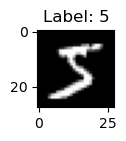

48000 12000


In [ ]:
# output ( (C,H,W), int)
print(test[0][0].dtype, type(test[0][1]))
print(f"Number of samples in the dataset: {len(test)}")

# get item helper
X, y = test[0]
print(X.shape, y, X.type(), type(y))

# display each digit
test.show_idx(0)

# split data
train, dev = test.train_dev_split(0.8)
print(len(train), len(dev))

### Instantiate from config file
It is convenient to keep setup of specific dataset for an experiment in a config file for reproductibility

[19:44:52] INFO - MNISTDataset: init
[19:44:52] INFO - ImageDataset: init


{'_target_': 'nimrod.image.datasets.MNISTDataset', 'data_dir': '../data/image', 'train': False, 'transforms': {'_target_': 'torchvision.transforms.ToTensor'}}
torch.float32 <class 'int'>
Number of samples in the dataset: 10000
torch.Size([1, 28, 28]) 7 torch.FloatTensor <class 'int'>


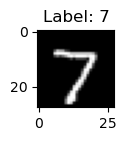

In [ ]:
# instantiate dataset from yaml config file
cfg = OmegaConf.load("../config/image/data/mnist.yaml")
print(cfg.dataset)
test = instantiate(cfg.dataset)
type(test)

# output ( (B,C, H,W), int)
print(test[0][0].dtype, type(test[0][1]))
print(f"Number of samples in the dataset: {len(test)}")

# get item helper
X, y = test[0]
print(X.shape, y, X.type(), type(y))

# display each digit
test.show_idx(0)

# split data
train, dev = test.train_dev_split(0.8)


### MNIST DataModule

In [ ]:
#| export

class MNISTDataModule(DataModule, LightningDataModule):
    def __init__(self,
                 data_dir: Optional[str] = "~/Data/", # path to source data dir
                 transforms: Union[transforms.Compose, Callable, None] = transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307,), (0.3081,))
                 ]),
                 train_val_test_split:List[float] = [0.8, 0.1, 0.1], # train val test %
                 batch_size: int = 64, # size of compute batch
                 num_workers: int = 0, # num_workers equal 0 means that it’s the main process that will do the data loading when needed, num_workers equal 1 is the same as any n, but you’ll only have a single worker, so it might be slow
                 pin_memory: bool = False, # If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory. This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer
                 persistent_workers: bool = False
                 ):

        logger.info("Init MNIST DataModule")
        super().__init__(train_val_test_split, batch_size, num_workers, pin_memory, persistent_workers)
        self.save_hyperparameters()

    @property
    def num_classes(self) -> int: # num of classes in dataset
        return 10

    def prepare_data(self) -> None:
        """Download data if needed 
        """
        # train set
        MNISTDataset(
            data_dir = self.hparams.data_dir,
            train=True,
        )
        # test set
        MNISTDataset(
            data_dir = self.hparams.data_dir,
            train=False
        )

    def setup(self, stage: Optional[str] = None) -> None:
        # called on every GPU when distrib
        # stage: {fit,validate,test,predict}\n",
        # concat train & test mnist dataset and randomly generate train, eval, test sets
        if not self.data_train or not self.data_val or not self.data_test:
            # ((B, H, W), int)
            trainset = MNISTDataset(self.hparams.data_dir, train=True, transforms=self.transforms)
            testset = MNISTDataset(self.hparams.data_dir, train=False, transforms=self.transforms)
            dataset = ConcatDataset(datasets=[trainset, testset])
            # TODO: keep test set untouched
            lengths = [int(split * len(dataset)) for split in self.hparams.train_val_test_split]
            self.data_train, self.data_val, self.data_test = random_split(dataset=dataset, lengths=lengths)
        

In [ ]:

# check for abstract methods
pprint([(name, getattr(method,"__isabstractmethod__", False)) for (name, method) in DataModule.__dict__.items()])


[('__module__', False),
 ('__init__', False),
 ('prepare_data', True),
 ('setup', True),
 ('train_dataloader', False),
 ('val_dataloader', False),
 ('test_dataloader', False),
 ('teardown', False),
 ('state_dict', False),
 ('load_state_dict', False),
 ('_sequential_split', False),
 ('__dict__', False),
 ('__weakref__', False),
 ('__doc__', False),
 ('__abstractmethods__', False),
 ('_abc_impl', False)]


### Usage

[19:44:56] INFO - Init MNIST DataModule
[19:44:56] INFO - MNISTDataset: init
[19:44:56] INFO - ImageDataset: init
[19:45:00] INFO - MNISTDataset: init
[19:45:00] INFO - ImageDataset: init
[19:45:04] INFO - MNISTDataset: init
[19:45:04] INFO - ImageDataset: init
[19:45:09] INFO - MNISTDataset: init
[19:45:09] INFO - ImageDataset: init


56000 7000 7000
X dim(B,C,W,H):  torch.Size([64, 1, 28, 28]) Y: dim(B) torch.Size([64])
torch.Size([1, 28, 28])
2 None
[9, 7, 9, 4, 4]


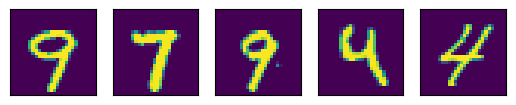

In [ ]:
#| notest

dm = MNISTDataModule(
    data_dir='../data/image',
    train_val_test_split=[0.8, 0.1, 0.1],
    batch_size = 64,
    num_workers = 0, # main process
    pin_memory= False,
    persistent_workers=False
)

# download or reference data from dir
dm.prepare_data()

# define train, eval, test subsets
dm.setup()

# len of splits
print(len(dm.data_train), len(dm.data_val), len(dm.data_test))

# access data batches via dataloader
test_dl = dm.test_dataloader()
X,Y = next(iter(test_dl))
print("X dim(B,C,W,H): ", X.shape, "Y: dim(B)", Y.shape)

# access data points directly by index
print(len(dm.data_test[0]), print(dm.data_test[0][0].shape))
imgs = [dm.data_test[i][0] for i in range(5)]

# display image samples
ImageDataset.show_grid(imgs)

# labels are ints
lbls = [dm.data_test[i][1] for i in range(5)]
print(lbls)

### Config

[19:45:12] INFO - Init MNIST DataModule
[19:45:12] INFO - MNISTDataset: init
[19:45:12] INFO - ImageDataset: init


{'_target_': 'nimrod.image.datasets.MNISTDataModule', 'data_dir': '../data/image', 'train_val_test_split': [0.8, 0.1, 0.1], 'batch_size': 64, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}


[19:45:17] INFO - MNISTDataset: init
[19:45:17] INFO - ImageDataset: init
[19:45:20] INFO - MNISTDataset: init
[19:45:20] INFO - ImageDataset: init
[19:45:24] INFO - MNISTDataset: init
[19:45:24] INFO - ImageDataset: init


<class 'nimrod.image.datasets.MNISTDataModule'>


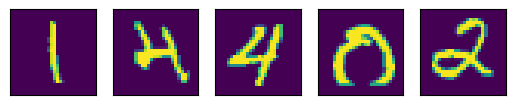

In [ ]:
#| notest

cfg = OmegaConf.load("../config/image/data/mnist.yaml")
print(cfg.datamodule)
dm = instantiate(cfg.datamodule)
dm.prepare_data()
dm.setup()
test_dl = dm.test_dataloader()
len(dm.data_test[0])
imgs = [dm.data_test[i][0] for i in range(5)]
ImageDataset.show_grid(imgs)
print(type(dm))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()